In [1]:
#!/usr/bin/env python
import numpy as np
#from copy import deepcopy
import scipy.interpolate

import numpy as np
import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec
from matplotlib import ticker
import copy
import xarray as xr

In [2]:
def shift_elements(arr, num, fill_value):
    """"shifting function, with a fill value;
        if just want to "roll it" use np.roll"""
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

In [3]:
def satvpw(T, param='murphykoop'):
    '''
    calculates saturation vapour pressure over water (hPa)
    using the Flatau et al., 1992 functions or
    GoffGratch or MurphyKoop functions (iCESM)
    '''

    if np.min(T) < 50:
      Ttr = 0
      Tk = T + 273.15
    else:
      Ttr = 273.15
      Tk = T

    if param == 'flatau':
        a1 = 6.11176750
        a2 = 0.443986062
        a3 = 0.143053301e-01
        a4 = 0.265027242e-03
        a5 = 0.302246994e-05
        a6 = 0.203886313e-07
        a7 = 0.638780966e-10

        esw = a1 + a2*(T-Ttr) + a3*(T-Ttr)**2 + a4*(T-Ttr)**3 + a5*(T-Ttr)**4     \
            + a6*(T-Ttr)**5 + a7*(T-Ttr)**6

    elif param == 'goffgratch':
        # uncertain below -70 C
        Tboil = 373.16
        esw = 10.**(-7.90298*(Tboil/Tk-1.)+ \
              5.02808*np.log10(Tboil/Tk)- \
              1.3816e-7*(10.**(11.344*(1.-Tk/Tboil))-1.)+ \
              8.1328e-3*(10.**(-3.49149*(Tboil/Tk-1.))-1.)+ \
              np.log10(1013.246))

    elif param == 'murphykoop':
        # (good for 123 < T < 332 K)
        esw = np.exp(54.842763 - (6763.22 / Tk) - (4.210 * np.log(Tk)) + \
              (0.000367 * Tk) + (np.tanh(0.0415 * (Tk - 218.8)) * \
              (53.878 - (1331.22 / Tk) - (9.44523 * np.log(Tk)) + \
              0.014025 * Tk))) / 100.

    return esw

def satvpi(T, param='murphykoop'):
    '''
    calculate saturation vapour pressure over ice (hPa)
    using the Flatau et al., 1992 functions or
    GoffGratch or MurphyKoop functions (iCESM)
    '''

    if np.min(T) < 50:
      Ttr = 0
      Tk = T + 273.15
    else:
      Ttr = 273.15
      Tk = T

    if param == 'flatau':
        a1=6.10952665
        a2=0.501948366
        a3=0.186288989e-01
        a4=0.403488906e-03
        a5=0.539797852e-05
        a6=0.420713632e-07
        a7=0.147271071e-09

        esi = a1 + a2*(T-Ttr) + a3*(T-Ttr)**2 + a4*(T-Ttr)**3 + a5*(T-Ttr)**4       \
             + a6*(T-Ttr)**5 + a7*(T-Ttr)**6

    elif param == 'goffgratch':
        h2otrip = 273.16

        esi = 10.**(-9.09718*(h2otrip/Tk-1.)-3.56654* \
           np.log10(h2otrip/Tk)+0.876793*(1.-Tk/h2otrip)+ \
           np.log10(6.1071)) #*100.

    elif param == 'murphykoop':
        esi = np.exp(9.550426 - (5723.265 / Tk) + (3.53068 * np.log(Tk)) \
                     - (0.00728332 * Tk)) / 100.

    return esi

In [4]:
#----------------------------------------------------------------------------------------
def dry_moistad_wice(T_0=293.15,p_0=1000.,fstop=0.2,zstop=40000.,dz=50.,rh_factor=1.,zstop_dry=500.):
    '''simulates pressure, temperature and humidity of an air parcel 
       during a moist adiabatic ascent starting at T_0 (K) and p_0 (hPa)
       stopping when f = fstop
       discretised with height steps of dz (m)
    '''

    g = 9.81         # gravitational acceleration
    cp = 1005.       # specific heat of dry air
    #Hv = 2257000.    # heat of vaporisation of water
    Hv = 2501000.    # from wiki and metpy
    Rd = 287.        # specific gas constant of dry air
    lamb = 0.004     # supersaturation tuning parameter => isotopes
    Tmmin = 238.15 #-35   # minimum temperature for mixed phase clouds
    Tmmax = 263.15 #-20   #273.15   # maximum temperature for mixed phase clouds
    #zstop_dry = 750 #dry adiabat from surface to 750 m, than moist 
    
    # supersaturation over ice and fr_liq as function of temp ###particularly relevant for isotopes
    T_ice = np.arange(99,Tmmin+0.1,0.1)
    T_liq = np.arange(Tmmax,399,0.1)
    Si_ice = 1. - lamb * (T_ice - Tmmax)
    #Si_ice = satvpi(alltemp)
    Si_liq = satvpw(T_liq)/satvpi(T_liq)
    Si_int = scipy.interpolate.InterpolatedUnivariateSpline(
        np.concatenate((T_ice,T_liq)),np.concatenate((Si_ice,Si_liq)),k=2) #quadratic interpolation
    fr_liq_ice = np.zeros(len(T_ice))
    fr_liq_liq = np.ones(len(T_liq))
    fr_liq_int = scipy.interpolate.InterpolatedUnivariateSpline(
        np.concatenate((T_ice,T_liq)),np.concatenate((fr_liq_ice,fr_liq_liq)),k=2) #quadratic interpolation
    #-----------
    
    # initialisation
    T_range = 1. / (Tmmax - Tmmin + 1e-16)
    k = 0
    z1 = 0.
    z = [0.]
    p = [p_0]
    T = [T_0]
    fr_liq = [fr_liq_int(T_0)]
    ewi = [fr_liq[0]*satvpw(T_0) + (1-fr_liq[0])*Si_int(T_0)*satvpi(T_0)] #sat mix pressure over water or ice depending on where we are
    wv = [ rh_factor * 0.622 * ewi[0] / (p_0 - ewi[0])]  #vapor saturation mixing ratio - saturated if rh_factor =1, BG added rh_factor!!!
    q = [wv[0] / (1 + wv[0]) * 1000.]   #??? for isotopes
    f = 1.
    
    Hvall = [(2.5 * 10**6) - (2.37 * 10**3)*(T_0 - 273.15)]
    Lapse_all = [0.]
    Lapsem_all = [0.]
    Lapsed_all = [0.]
    # dry adiabatic lapse rate
    L_d = g / cp

            
    #while f > fstop: #based on moisture
    #######BG HERE ONLY FOR DRY ADIABAT########################
    while z1 < zstop_dry: 
        z.append(z[k] + dz)
        #Told = T[k]
        Hv = (2.5 * 10**6) - (2.37 * 10**3)*(T[k] - 273.15)
        # dry adiabatic lapse rate

        T.append(T[k] - L_d*dz)
        p.append(p[k] * (T[k+1]/T[k]) ** (g/(Rd*L_d)))

        
        #only water considered for dry adiabat, we are at warm temp
        ewi.append(satvpw(T[k+1],'murphykoop'))
        #ewi.append(fr_liq[k+1]*satvpw(T[k+1]) + (1-fr_liq[k+1])*Si_int(T[k+1])*satvpi(T[k+1]))
        wv.append(0.622 * ewi[k+1] / (p[k+1] - ewi[k+1]) * rh_factor) #BG added rh_factor!!!
        q.append(wv[k+1] / (1 + wv[k+1]) * 1000.)
        
        Hvall.append(Hv)
        
        Lapsed_all.append(L_d) #BGBGBGB

        f = q[k+1]/q[0]
        z1 = z[k]
        k = k+1        
        
        fr_liq.append(1.0)
    ############HERE MOIST ADIABAT######################
    while z1 < zstop:
        z.append(z[k] + dz)
        #Told = T[k]
        Hv = (2.5 * 10**6) - (2.37 * 10**3)*(T[k] - 273.15)
        # moist adiabatic lapse rate
        L_m = L_d * (1 + Hv*wv[k]/(Rd*T[k]))/(1 + Hv**2*wv[k]*0.622/(cp*Rd*T[k]**2))
        #print(L_m)
        Lapsem_all.append(L_m)

        T.append(T[k] - L_m*dz)
        p.append(p[k] * (T[k+1]/T[k]) ** (g/(Rd*L_m)))

        #limit fr_liq between 1 and 0
        if (T[k+1]>Tmmax) or (fr_liq_int(T[k+1])>1.):
            fr_liq.append(1.0)
        elif (T[k+1]<Tmmin) or (fr_liq_int(T[k+1])<0.):
            fr_liq.append(0.0)
        else:
            fr_liq.append(fr_liq_int(T[k+1])) 

        #water and ice here
        ewi.append(fr_liq[k+1]*satvpw(T[k+1]) + (1-fr_liq[k+1])*Si_int(T[k+1])*satvpi(T[k+1]))
        #only water considered: increases T at anvil level by 1 K or so
        #ewi.append(satvpw(T[k+1],'murphykoop'))
        wv.append(0.622 * ewi[k+1] / (p[k+1] - ewi[k+1]) * rh_factor) #BG added rh_factor!!!
        q.append(wv[k+1] / (1 + wv[k+1]) * 1000.)

        Hvall.append(Hv)

        f = q[k+1]/q[0]
        z1 = z[k]
        k = k+1
    Lapsed_all = np.array(Lapsed_all)
    Lapsem_all = np.array(Lapsem_all)
    Lapse_all = np.array(Lapse_all)
    Lapse_all=np.concatenate((Lapsed_all,Lapsem_all[1:]),axis=0)
    return np.array(z),np.array(p),np.array(T),np.array(q),np.array(ewi),np.array(Lapse_all)#,np.array(Lapsem_all) #np.array(Hvall),np.array(wv/satvpw(T[k]))

In [5]:
#here compute the moist adiabatic lapse rate and T profile
#we start with T=293 because that fits better RCEMIP simulations than T=295K
#and in second step use the same logic for 305 K simulations; i.e. instead of starting at 305, we start at 303K 
moistadi_100_295 = dry_moistad_wice(T_0=293,p_0=1000.,fstop=0.0008,zstop=20000.,dz=50.,rh_factor=1,zstop_dry=600)
moistadi_100_305 = dry_moistad_wice(T_0=303,p_0=1000.,fstop=0.0008,zstop=20000.,dz=50.,rh_factor=1,zstop_dry=600)

Spectral Plume Model, based on Zhou and Xie, 2019 (10.1175/JAS-D-18-0330.1).

The code below was originally written in Matlab by Dennis L. Hartmann (University of Washington), and translated into python by Blaz Gasparini (University of Vienna)

Using also some bits and pieces of the code/basic thermodynamics and thermodynamical constants by Jiawei Bao/Bjorn Stevens (Max Planck Institute for Meterorology).

In [6]:
#useful constants for atmospheric thermodynamics--------
#copied from the aes_thermo_ice2.py script

"""
Created on Tuesday, May 22, 2019
Author: Bjorn Stevens (bjorn.stevens@mpimet.mpg.de)
"""
#
import numpy as np
from scipy import interpolate, optimize

gravity = 9.8076

cpd     = 1006.
Rd      = 287.05

Rv      = 461.53    # IAPWS97 at 273.15
cpv     = 1865.01   # ''
cpl     = 4219.32   # '' 
cpi     = 2096.70   # ''
lv0     = 2500.93e3 # ''
lf0     =  333.42e3 #''

eps1     = Rd/Rv
eps2     = Rv/Rd -1.


P0      = 100000.  # Standard Pressure [Pa]
T0      = 273.15   # Standard Temperature [K]
e0      = 611.2    # This is the saturation vapor pressure at T0 [K]
sd00    = 6783     # Dry air entropy at P0, T0
sv00    = 10321    # Water vapor entropy at P0, T0
PvC     = 22.064e6 # Critical pressure [Pa] of water vapor
TvC     = 647.096  # Critical temperature [K] of water vapor
TvT     = 273.16   # Triple point temperature [K] of water
PvT     = 611.655
#T_ice   = 233.15
T_ice   = 240.15 #below -33 C only ice

In [7]:
def e_sat(T):

    esl = PvT*(T/T0)**((cpv-cpl)/Rv)*np.exp( ( lv0 - T0*(cpv-cpl) )/Rv * ( 1./T0 - 1./T ) )
    esi = PvT*(T/T0)**((cpv-cpl)/Rv)*np.exp( ( lv0 + lf0 - T0*(cpv-cpl) )/Rv * ( 1./T0 - 1./T ) )
    
    fliq,fice = calc_fice(T)
    
    es = fliq*esl + fice*esi
    
    return es
    
def qq_sat(TK,PPa,qt=None) :

    Psat = e_sat(TK)
        
    rs = Rd/Rv * Psat/(PPa-Psat)
    
    if qt is not None:
        rt = qt/(1-qt)
        qs  = rs / (1+max(rt,rs))
    else:
        qs = rs/(1+rs)
    return qs


def calc_fice(T):

    fliq = (T-T_ice)/(T0-T_ice)
    fliq = np.where(fliq<0,0,fliq)
    fliq = np.where(fliq>1,1,fliq)
    fice = 1-fliq
    return fliq, fice

In [8]:
def PlumeModifiedEuler(h0, z, c, RHS):
    # initialize output
    h = np.zeros(len(z))
    # value of h at the surface
    h[0] = h0
    for k in range(1, len(z)):
        # predict the value h(k) using forward Euler
        h_eul = h[k-1] + (z[k]-z[k-1]) * (c[k-1]*h[k-1] + RHS[k-1])
        # Now use the trapezoidal rule to integrate from k-1 to k using h_eul in place of h(k)
        h[k] = h[k-1] + 0.5*(z[k]-z[k-1])*(c[k-1]*h[k-1] + RHS[k-1] + c[k]*h_eul + RHS[k])
    return h

In [9]:
#determine entrainment profile
def EPS(Z, params):
    #global ztop_conv
    # eps0=3.e-4;  # 0.3 km-1
    EPS = params["ent"] * ((ztop_conv - Z) / (ztop_conv - params["zb"])) ** params["entexp"]
    EPS[Z < params["zb"]] = 0.0
    EPS[Z > ztop_conv] = 0.0
    return EPS

In [10]:
def LAM(eps, z, params):
    #global ztop_conv
    # Comput Lambda for spectral plume model
    lam = -1.0 / ((ztop_conv - z) + eps * (ztop_conv - z) * (z - params["zb"]))
    lam[np.isnan(lam)] = 0.0
    lam[z < params["zb"]] = 0.0
    lam[z > ztop_conv] = 0.0
    lam = np.maximum(lam, -2e-2)
    return lam

In [11]:
def RHS(T, p, ent, params):
    # computes the right hand side of the spectral plume model
    # Pseudo moist adiabatic lapse rate calculator with entrainment E

    # Use Blossey script for constants and evaluation of ws
    g = 9.8
    Cp = 1005
    Rd = 287
    L = 2.5e6
    Ls = 3.34e5

    Eice=1
    # set water vapor amount based on RH profile
    if Eice == 1:
        rhs = -L * ent * (1 - rh_profile) * qq_sat(T,p) / Cp  # blended saturation
        #rhs = -L * ent * (1 - rh_profile) * satvpi(T - 273.18, p * 0.01) / Cp  # blended saturation
    else:
        #only liquid - modify it, dont have qsw_mk2005
        rhs = -L * ent * (1 - rh_profile) * qsw_mk2005(p, T) / Cp  # Liquid Saturation

    return rhs

In [12]:
#This code defines a Python class called "DefaultRCEParams". The class has a constructor method __init__() 
#which gets called automatically when an object of this class is created. 
#The constructor method initializes the object with a set of attributes

class DefaultRCEParams:
    def __init__(self):
        self.lapse1 = 5.0
        self.Psfc = 1013e2 # surface pressure in Pa
        self.ent = 3.0e-4 # Entrainment parameter for Spectral Plume Model
        self.entexp = 1.0
        self.zt = 16000.
        self.zb = 1000.

In [13]:
#calculate the 305 K SPM adjustment to the moist adiabatic lapse rate

#the interface for the SPM calculation of deviation from moist adiabatic lapse rate
ztop_conv = 14000  #14 km is best for 305, 11 km best for 295; best with RH = 80, and following fixed cloud base and entr param %
params = {
    'zb': 600,
    'ent': 3e-4, #=0.3 km-1
    'entexp': 1.0
}
#z = np.arange(0, 20001, 100)
z = moistadi_100_305[0]
levs = len(z)
rh = np.ones(levs) * 0.8
rh_profile = rh.T
#default profiles - change to sth more meaningful!
#pres = 1e5 * np.exp(z / 7600)
#Tatm = 300 - 5.0 * z / 1000

Tatm = moistadi_100_305[2]

pres = moistadi_100_305[1] * 100
L = 2.5e6
Cp = 1004
Rv = 461
g = 9.81
h0 = 0

qt = np.ones(levs)*0.

eps1 = EPS(z,params)
lam1 = LAM(eps1,z,params)
rhs1 = RHS(Tatm,pres,eps1,params)
h_plume = PlumeModifiedEuler(h0,z,lam1,rhs1)

cnstt = (L * L) / (Rv * Cp)
#bigfac = 1.0 + cnstt * qsat2(Tatm,pres) / Tatm / Tatm
bigfac = 1.0 + cnstt * qq_sat(Tatm,pres) / (Tatm * Tatm)
deltaT = h_plume / bigfac
deltaT305 = np.copy(deltaT) #305 K temperature profiles here

/tmp/ipykernel_2944521/3538228680.py:4: RuntimeWarning: divide by zero encountered in true_divide
  lam = -1.0 / ((ztop_conv - z) + eps * (ztop_conv - z) * (z - params["zb"]))


In [14]:
#calculate the 295 K SPM adjustment to the moist adiabatic lapse rate

#the interface for the SPM calculation of deviation from moist adiabatic lapse rate
ztop_conv = 11000  #14 km is best for 305, 11 km best for 295; best with RH = 80, and following fixed cloud base and entr param %
params = {
    'zb': 600,
    'ent': 3e-4, #=0.3 km-1
    'entexp': 1.0
}
z = moistadi_100_295[0]
levs = len(z)
rh = np.ones(levs) * 0.8
rh_profile = rh.T

Tatm = moistadi_100_295[2]

pres = moistadi_100_295[1] * 100
L = 2.5e6
Cp = 1004
Rv = 461
g = 9.81
h0 = 0
qt = np.ones(levs)*0.

eps1 = EPS(z,params)
lam1 = LAM(eps1,z,params)
rhs1 = RHS(Tatm,pres,eps1,params)
h_plume = PlumeModifiedEuler(h0,z,lam1,rhs1)

cnstt = (L * L) / (Rv * Cp)
bigfac = 1.0 + cnstt * qq_sat(Tatm,pres) / (Tatm * Tatm)
deltaT = h_plume / bigfac
deltaT295 = np.copy(deltaT) #295 K temperature profiles here

/tmp/ipykernel_2944521/3538228680.py:4: RuntimeWarning: divide by zero encountered in true_divide
  lam = -1.0 / ((ztop_conv - z) + eps * (ztop_conv - z) * (z - params["zb"]))


In [16]:
#load the RCEMIP processed data
path = '../../data/RCEMIP_processed/'

ssts = ['295','300','305']
#ssts = ['300']
col = ['k','orange','crimson']

plt.rcParams.update({'font.size': 18}) #all to 18 if not specified other

variables = ['temperature']
units = ['K/day','K/day','1','kg/kg','kg/kg']
units = ['K/day','K/day','K/day','1','kg/m3','kg/kg']

ds1 = xr.open_dataset(path+'RCElarge_z24_merged_1D_averages_multiplevars2.nc')

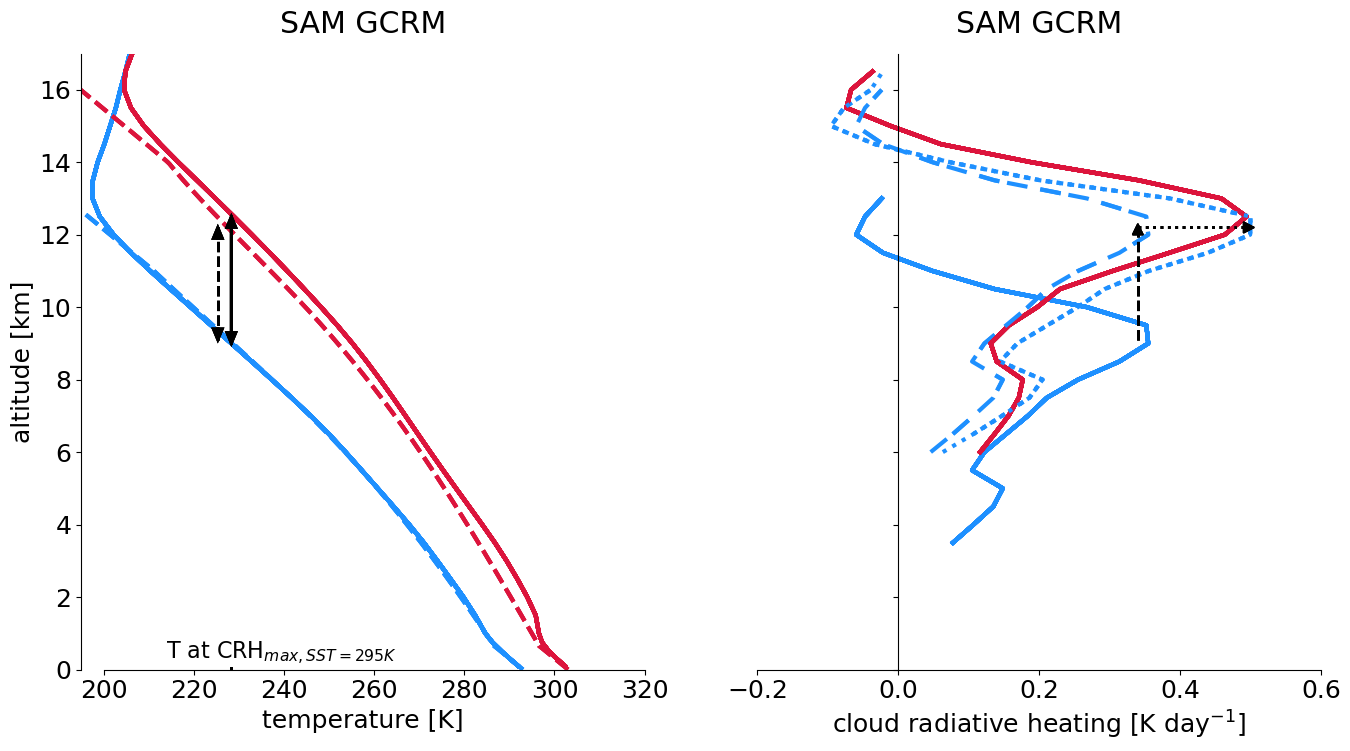

In [17]:
#EXAMPLE SAM GCRM!!!!
models = ['MESONH','NICAM','SAM_CRM','SAM_GCRM','SCALE','dam','MPAS','UCLA-CRM','CAM5_GCM',
          'CAM6_GCM','CNRM-CM6-1','GEOS_GCM','ICON_LEM_CRM','ICON_NWP_CRM','SP-CAM','SPX-CAM','UKMO-GA7.1','CM1']
variables = ['temperature','hr_acre','ice_mixing_ratio','density']

ncol = ['lightgray','gray','gray']
ncol = ['dodgerblue','k','crimson']

ds1['ice_water_content']=ds1['density']*ds1['ice_mixing_ratio']

fig = plt.figure()
fig.set_size_inches(16,8,forward=True)
gs = gridspec.GridSpec(1,2,height_ratios=[1],width_ratios=2*[1])

y0 = [0,0,0,2,2,2,4,4,4,6,6,6,8,8,8,10,10,10,12,12,12]
x0 = [0,10,20]*6
for v,variable in enumerate(variables[:2]):
    ax = fig.add_subplot(gs[0,v])

    for s,sst in enumerate(ssts):
            if s ==1:
                pass
            else:
                for m,model in enumerate(models):
                    plotvar = (ds1[variable][3]).values
                    if v==1:
                        plotvar[s][ds1['temperature'][3][s].values>273.15]=np.nan
                        plotvar[s][ds1['ice_water_content'][3][s].values<1e-8]=np.nan

                    plt.plot(plotvar[s], ds1['alt'].values,color=ncol[s],linewidth=3,linestyle='-') #color=col[s],linewidth=1,linestyle='--') 

            if v ==0:               
                plt.plot(moistadi_100_295[2]+deltaT295,moistadi_100_295[0]/1e3,'dodgerblue',label='RH=90 hvtemp',linewidth=3,linestyle='--')
                plt.plot(moistadi_100_305[2]+deltaT305,moistadi_100_305[0]/1e3,'crimson',label='RH=90 hvtemp',linewidth=3,linestyle='--')

                #arrow ideal shift
                plt.arrow(x=ds1['temperature'][3][0][np.nanargmax(ds1['hr_acre'][3][0])], y=9, dx=0, dy=3.5,color='k',linewidth=2,
                          head_length = 0.3, head_width = 2, length_includes_head = True,zorder=111)
                plt.arrow(x=ds1['temperature'][3][0][np.nanargmax(ds1['hr_acre'][3][0])], y=12.5, dx=0, dy=-3.5,color='k',linewidth=2,
                          head_length = 0.3, head_width = 2, length_includes_head = True,zorder=111)         
                #arrow predicted shift
                plt.arrow(x=-3+ds1['temperature'][3][0][np.nanargmax(ds1['hr_acre'][3][0])], y=9.3, dx=0, dy=-0.2,color='k',linewidth=2,
                          head_length = 0.3, head_width = 2, length_includes_head = True,zorder=111)
                plt.arrow(x=-3+ds1['temperature'][3][0][np.nanargmax(ds1['hr_acre'][3][0])], y=12., dx=0, dy=0.2,color='k',linewidth=2,
                          head_length = 0.3, head_width = 2, length_includes_head = True,zorder=111)               

                plt.vlines(x=-3+ds1['temperature'][3][0][np.nanargmax(ds1['hr_acre'][3][0])],ymin=9.1,ymax=12.2,linestyle='--', color = 'k',linewidth=2)

                plt.vlines(x=ds1['temperature'][3][0][np.nanargmax(ds1['hr_acre'][3][0])],ymin=-0.1,ymax=0.4, color = 'k',linewidth=2)

                plt.xlim(195,320)
                plt.xlabel('temperature [K]')

                plt.text(0.15,0.05,'T at CRH$_{max,SST=295K}$',transform=ax.transAxes,horizontalalignment='left',
                verticalalignment='top',fontsize=16,color='black',bbox=dict(facecolor='white', edgecolor='none', pad=1))

                ax.spines['bottom'].set_bounds(200,320)
            else:
                plt.xlim(-0.2,0.6)
                plt.xlabel('cloud radiative heating [K day$^{-1}$]')

                #1. isothermal CRH shift
                #from below I know it's 3km = 6 indices here
                gsam_shift=shift_elements(plotvar[0],6,0) 
                gsam_shift[ds1['temperature'][3][2].values>273.15]=np.nan
                gsam_shift[ds1['ice_water_content'][3][2].values<1e-8]=np.nan
                plt.plot(gsam_shift,ds1['alt'].values,'dodgerblue',linestyle=(0, (5, 10)),linewidth=3)

                #2. density factor 
                gsam_dens_shift=shift_elements(ds1['density'][3][0],6,0)
                gsam_densfac=gsam_dens_shift/ds1['density'][3][0]
                gsam_densfac[ds1['temperature'][3][2].values>273.15]=np.nan
                gsam_shift[ds1['ice_water_content'][3][2].values<1e-8]=np.nan
                plt.plot(gsam_shift*gsam_densfac,ds1['alt'].values,'dodgerblue',linestyle=':',linewidth=3)

                ax.spines['left'].set_position(('data',0))
                ax.tick_params(axis='y', which='major', pad=35)
                #ax.spines['left'].set_visible(False)
                ax.get_yaxis().set_ticklabels([])

                #arrow ideal shift
                plt.arrow(x=0.34, y=12.1, dx=0, dy=0.2,color='k',
                          head_length = 0.3, head_width = 0.015, length_includes_head = True,zorder=111)
                plt.vlines(x=0.34,ymin=9.1,ymax=12.2,linestyle='--', color = 'k',linewidth=2)
                #arrow intensity 
                plt.arrow(x=0.49, y=12.2, dx=0.015, dy=0.0,color='k',
                          head_length = 0.015, head_width = 0.3, length_includes_head = True,zorder=111)
                plt.hlines(y=12.2,xmin=0.34,xmax=0.49,linestyle=':', color = 'k',linewidth=2)

            plt.ylim(0,17)

    #ax.spines['left'].set_position(('data',0))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['left'].set_visible(False)

    if np.mod(v,3)==0:
        plt.ylabel('altitude [km]')
    plt.title('SAM GCRM',y=1.02)        
#plt.savefig('/path-to-file/methodfigure.pdf',bbox_inches='tight')       